In [1]:
%matplotlib inline
import numpy as onp
import jax.numpy as np
from jax.ops import index, index_update
from jax.config import config
from tqdm.notebook import trange

from data_utilities import create_covariances
import functions_utilities as utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('talk', 'white')
plt.rcParams["figure.figsize"] = (15,15)

config.update("jax_enable_x64", True)


In [2]:
# Functions
isqrt = lambda x: 1. / np.sqrt(x)
funs = {'sqrt': np.sqrt,
        'isqrt': isqrt,
        'log': np.log,
        'exp': np.exp}

def norm_frob_squared(X):
    return np.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = np.linalg.eigh(X)
    return np.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = np.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return np.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return np.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)

def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.power(np.prod(u, axis=0), 1 / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(Sigmas)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    return np.einsum('...i,...ij,...j->...ij', 1./diag, cov, 1./diag)


In [3]:
Number_of_Subjects = 10
Last_subject = Number_of_Subjects
Dimension_of_Covariances = 15

Sigmas = np.zeros(shape=(2 * Number_of_Subjects, Dimension_of_Covariances, Dimension_of_Covariances))
closed_eye = np.zeros(shape=(Number_of_Subjects, Dimension_of_Covariances, Dimension_of_Covariances))
opened_eye = np.zeros(shape=(Number_of_Subjects, Dimension_of_Covariances, Dimension_of_Covariances))

for i in trange(Number_of_Subjects):
    subject = i + 1
    try:
        c, o = create_covariances(subject)
    except FileNotFoundError:
        print('Subject {} does not exists')
        Last_subject = i
        break
    Sigmas = index_update(Sigmas, i, o)
    Sigmas = index_update(Sigmas, Number_of_Subjects + i, o)


  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
ref_eigvals = optimal_reference_eigval(Sigmas)
ref_eigvect = optimal_reference_eigvec(Sigmas)
reference = np.einsum('...ij,...j,...kj', ref_eigvect, ref_eigvals, ref_eigvect)

Omegas = optimal_rotation(Sigmas, reference)

Sigmas_rotated = utils.rotate(Sigmas, Omegas)

In [5]:
#s_max_or, s_min_or = np.max(Sigmas), np.min(Sigmas)
#s_max_ro, s_min_ro = np.max(Sigmas_rotated), np.min(Sigmas_rotated)
s_max_or, s_min_or = 1., -1.
s_max_ro, s_min_ro = 1., -1.
colmap = sns.diverging_palette(20, 220, n=200)
mask = np.zeros(shape=(Dimension_of_Covariances, Dimension_of_Covariances))
mask = index_update(mask, np.triu_indices_from(mask), True)
base = 6
figsize = (base * 2, base * Number_of_Subjects)

OPEN EYES


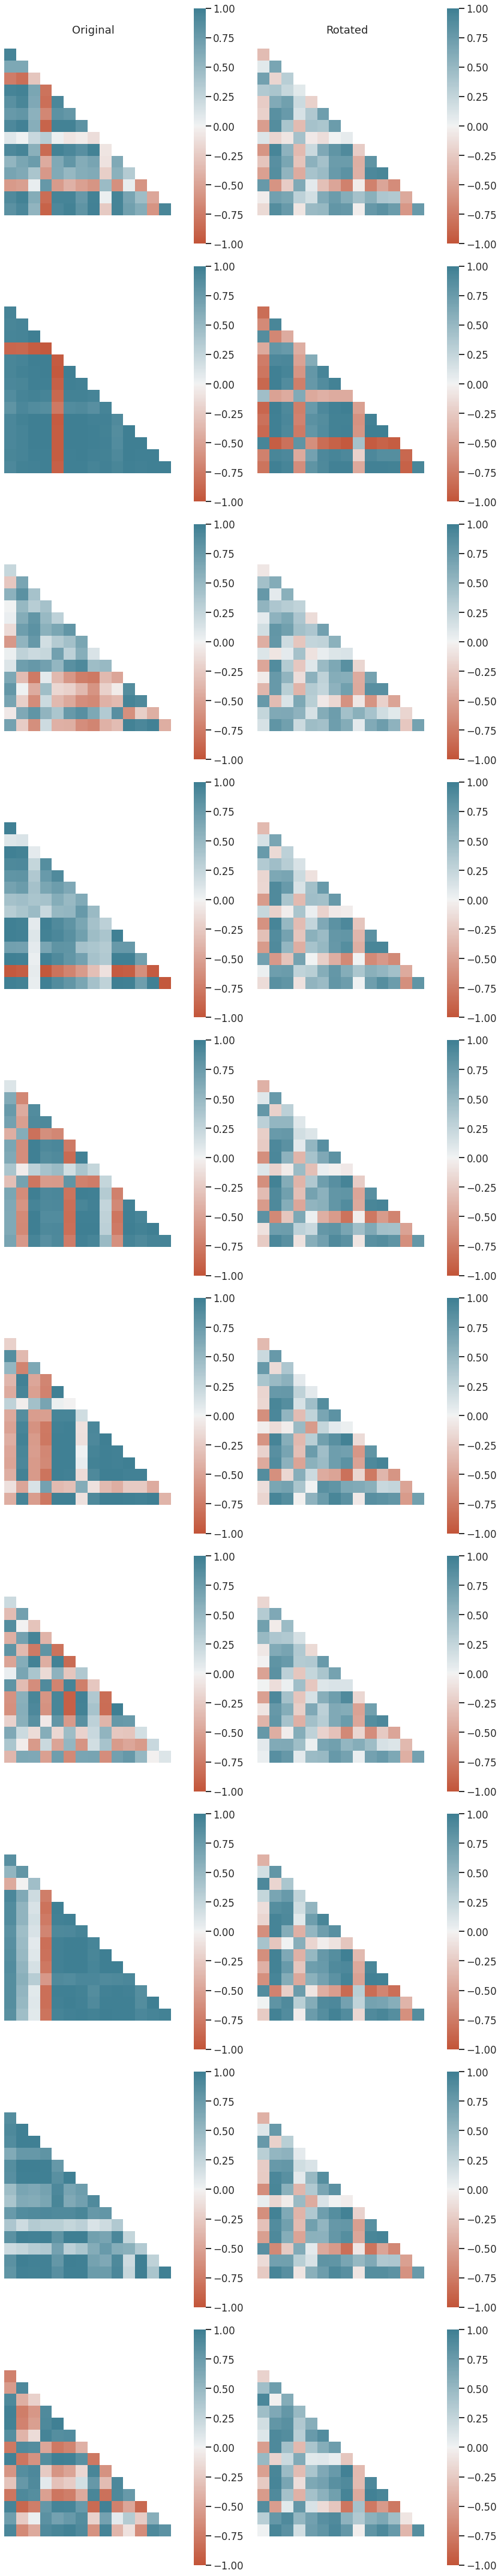

In [6]:
print("OPEN EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
#f.suptitle('Open eyes')
f.set_tight_layout(tight=True)
plt.show()


CLOSED EYES


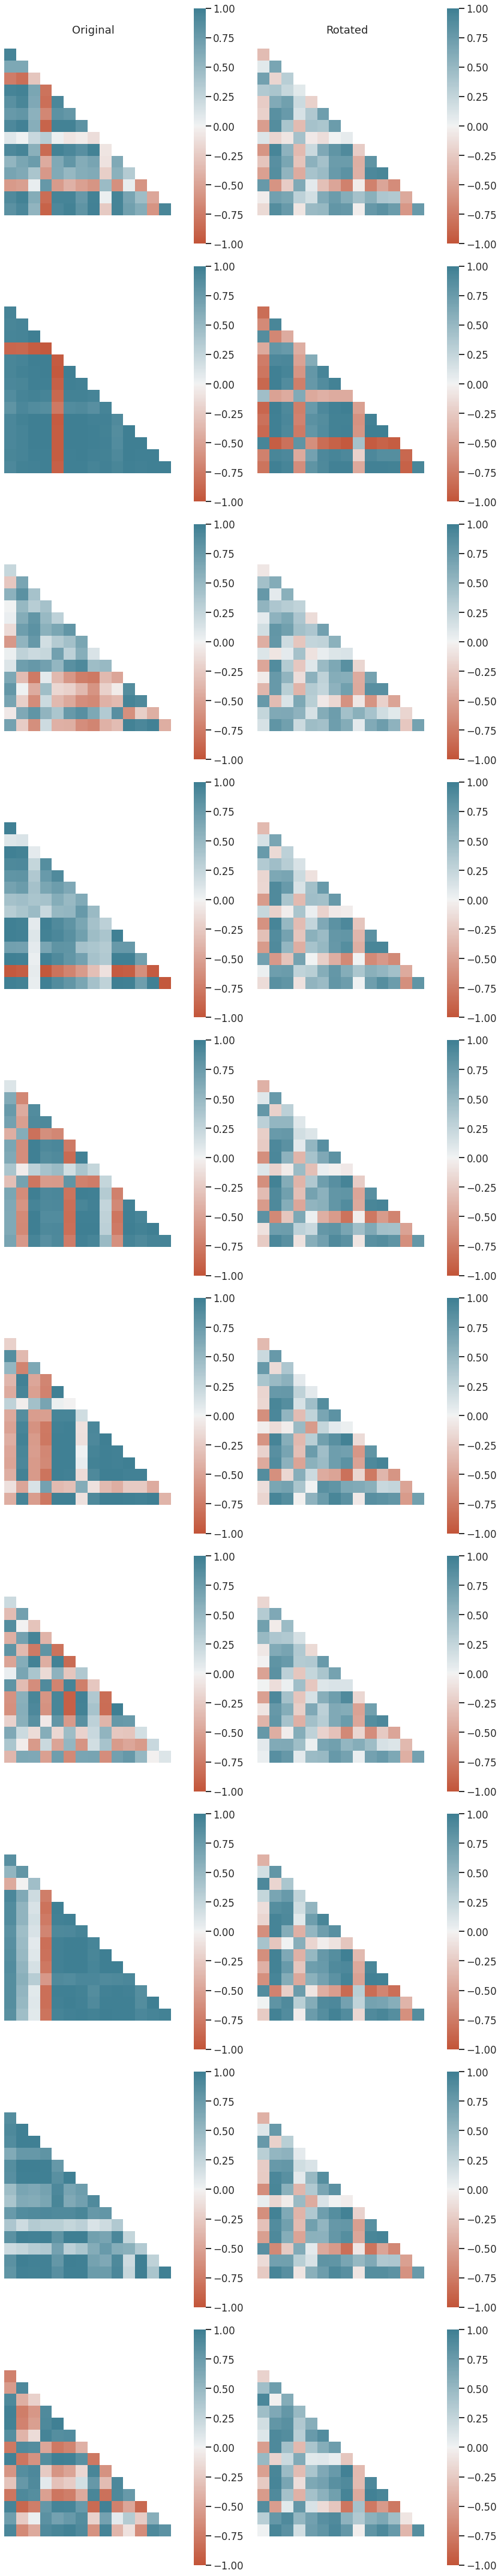

In [7]:
print("CLOSED EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[Number_of_Subjects + i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[Number_of_Subjects + i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
# f.suptitle('Closed eyes')
f.set_tight_layout(tight=True)
plt.show()


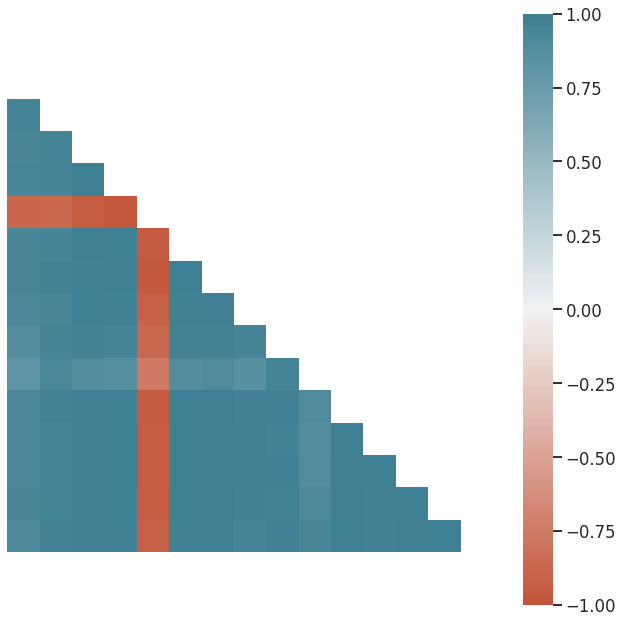

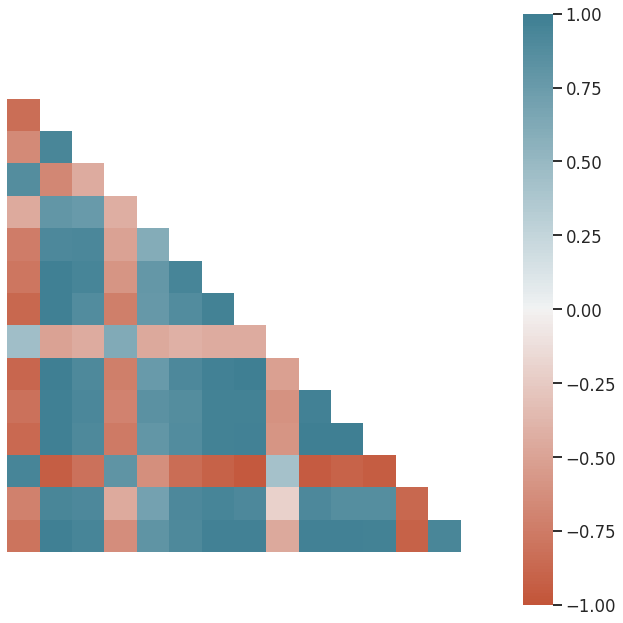

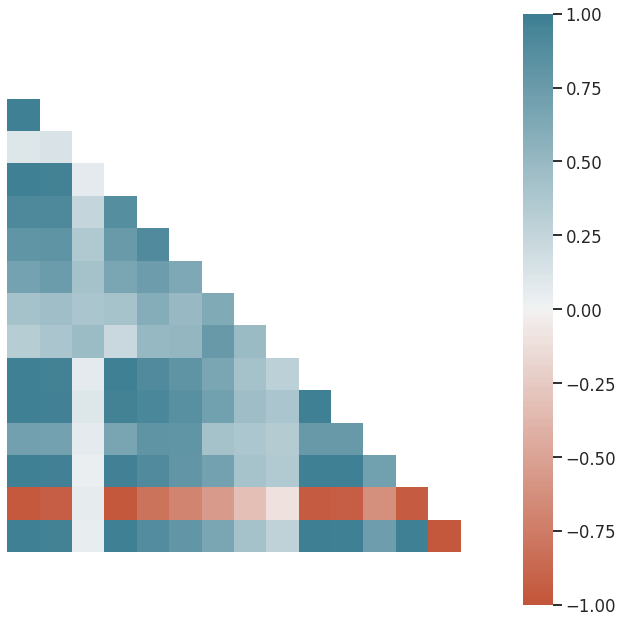

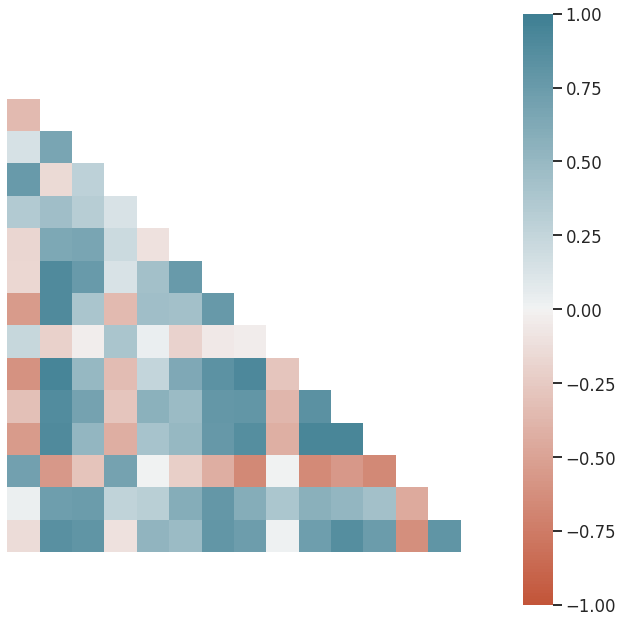

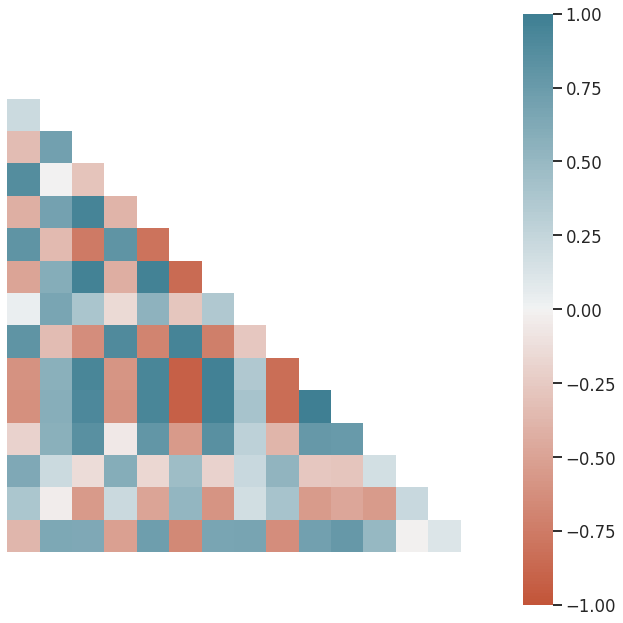

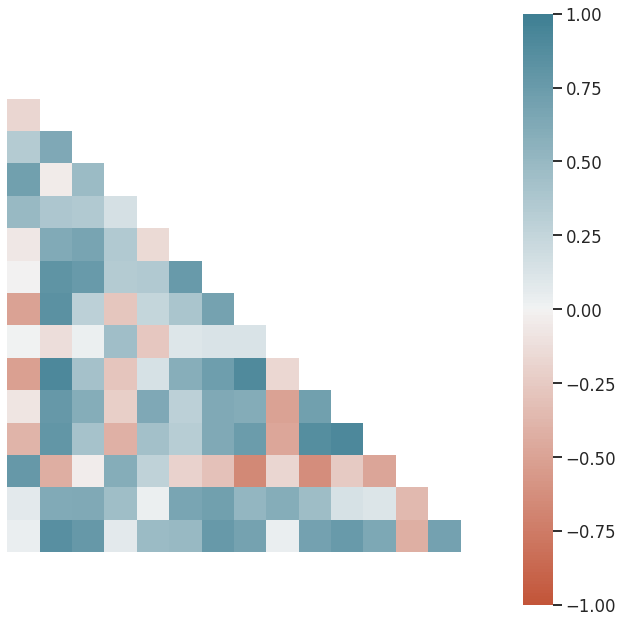

In [9]:
f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1_rot.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3_rot.pdf')
plt.show()


f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6_rot.pdf')
plt.show()

In [10]:
from jax import jit, grad
from optispd.manifold import SPD
from optispd.minimizer import minimizer

def karcher(sigmas):
    cost = jit(lambda x: np.sum(dist_riem_squared(x, sigmas)))
    gr = jit(grad(cost))
    init = sigmas[0]
    
    man = SPD(Dimension_of_Covariances)
    opti = minimizer(man, 'rsd', verbosity=1, maxiter=100)
    res = opti.solve(cost, gr, x=init)
    return res.x
    
ori_bar = karcher(Sigmas)
#ori_bar_close = karcher(Sigmas[Number_of_Subjects:])
#ori_bar_open = karcher(Sigmas[:Number_of_Subjects])
rot_bar = karcher(Sigmas_rotated)
#rot_bar_close = karcher(Sigmas_rotated[Number_of_Subjects:])
#rot_bar_open = karcher(Sigmas_rotated[:Number_of_Subjects])


Starting Riemannian Steepest Descent on manifold of (15 x 15) positive definite matrices
Optimization not completed.	29 iterations in 3.157 s
Starting Riemannian Steepest Descent on manifold of (15 x 15) positive definite matrices
Optimization completed.	7 iterations in 0.491 s


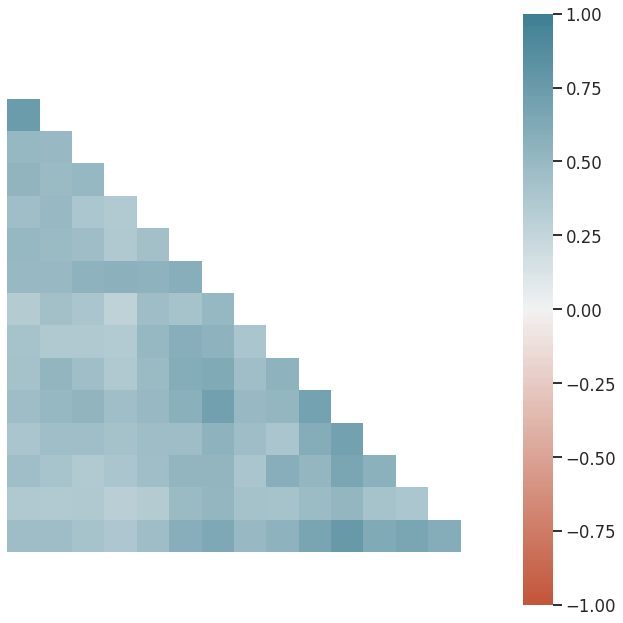

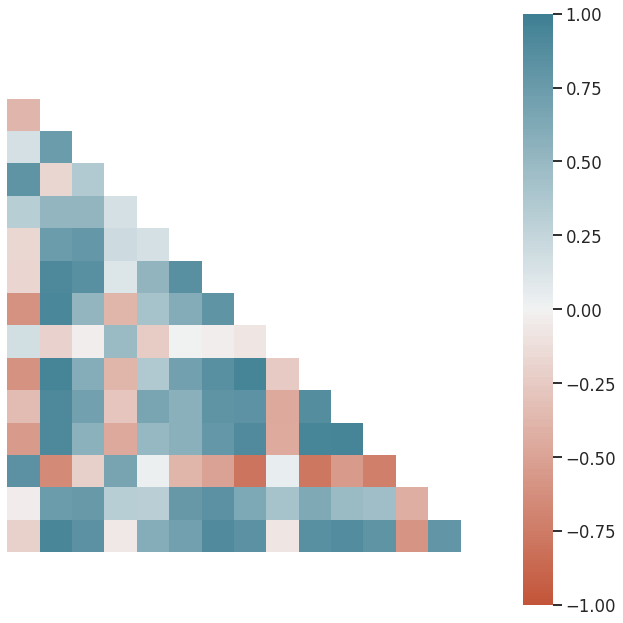

In [12]:
f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(ori_bar)), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/bari.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(rot_bar)), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/bari_rot.pdf')
plt.show()

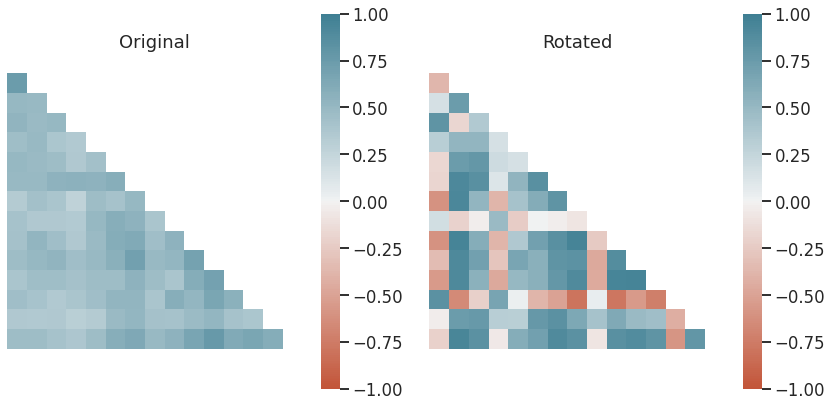

In [11]:
figsize = (base * 2, base)
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()

In [ ]:
print("CLOSED EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_close)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_close)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()

In [ ]:
print("OPEN EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_open)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_open)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()